In [103]:
# IMPORTS
import math
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.dates as mdates
import pickle
import pandas_datareader as webreader
import datetime as dt
import pandas_ta as ta
import tensorflow.keras as keras
from math import sqrt



from keras.models import Sequential, load_model
from keras.layers import Dense
from keras.layers import GRU
from keras.layers import Dropout
from keras.layers import *
from keras import optimizers
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from datetime import date, timedelta, datetime
from sklearn.model_selection import train_test_split
from pandas.plotting import register_matplotlib_converters
from tensorflow.python.client import device_lib


device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 10931569101389643139,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 1375462196
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 255479311059561452
 physical_device_desc: "device: 0, name: NVIDIA GeForce MX150, pci bus id: 0000:01:00.0, compute capability: 6.1"]

In [104]:
#Build and train the model
def fit_model(train,val,timesteps,hl,lr,batch,epochs):
    X_train = []
    Y_train = []
    X_val = []
    Y_val = []
  
    # Loop for training data
    for i in range(timesteps,train.shape[0]):
        X_train.append(train[i-timesteps:i])
        Y_train.append(train[i][0])
    X_train,Y_train = np.array(X_train),np.array(Y_train)
  
    # Loop for val data
    for i in range(timesteps,val.shape[0]):
        X_val.append(val[i-timesteps:i])
        Y_val.append(val[i][0])
    X_val,Y_val = np.array(X_val),np.array(Y_val)
    
    # Adding Layers to the model
    model = Sequential()
    model.add(GRU(X_train.shape[2],input_shape = (X_train.shape[1],X_train.shape[2]),return_sequences = True,
                   activation = 'tanh'))
    for i in range(len(hl)-1):        
        model.add(GRU(hl[i],activation = 'tanh',return_sequences = True))
    model.add(GRU(hl[-1],activation = 'tanh'))
    model.add(Dense(1))
    model.compile(optimizer = tf.keras.optimizers.Adam(lr), loss = 'mean_squared_error')
    print(model.summary())
  
    # Training the data
    early_stop = EarlyStopping(monitor='loss', patience=500, verbose=1)
    history = model.fit(X_train,Y_train,epochs = epochs,batch_size = batch,validation_data = (X_val, Y_val),verbose = 1,
                        shuffle = False, callbacks=early_stop)
    model.reset_states()
    return model, history.history['loss'], history.history['val_loss']

In [105]:
# Evaluating the model
def evaluate_model(model,test,timesteps):
    X_test = []
    Y_test = []
    # Loop for testing data
    for i in range(timesteps,test.shape[0]):
        X_test.append(test[i-timesteps:i])
        Y_test.append(test[i][0])
    X_test,Y_test = np.array(X_test),np.array(Y_test)
    #print(X_test.shape,Y_test.shape)
  
    # Prediction Time !!!!
    Y_hat = model.predict(X_test)
    mse = mean_squared_error(Y_test,Y_hat)
    rmse = sqrt(mse)
    r = r2_score(Y_test,Y_hat)
    # Mean Absolute Percentage Error (MAPE)
    mape = np.mean((np.abs(np.subtract(Y_test, Y_hat)/ Y_test))) * 100
    # Median Absolute Percentage Error (MDAPE)
    mdape = np.median((np.abs(np.subtract(Y_test, Y_hat)/ Y_test)) ) * 100
    return mse, rmse, r, Y_test, Y_hat, mape, mdape

In [107]:
# COMMON
symbol = '^IBEX'
stockname = 'IBEX'
timeWindowInYears = 15
timeWindowInDays = timeWindowInYears * 365
testDays = 100

In [108]:
# PULL DATASET FROM YAHOO FINANCIALS
today = datetime(2022, 3, 1)
date_today = today.strftime("%Y-%m-%d")
date_start = pd.Timestamp('2022-03-01') - timedelta(days=timeWindowInDays)
print(date_today)
df = webreader.DataReader(symbol, data_source='yahoo', start=date_start, end=date_today)
df.head()

2022-03-01


High           Low          Open         Close    Volume  \
Date                                                                           
2007-03-05  13830.200195  13654.900391  13689.799805  13749.099609  327800.0   
2007-03-06  13859.299805  13768.000000  13843.099609  13825.900391  224600.0   
2007-03-07  13958.799805  13823.799805  13919.200195  13912.700195  232200.0   
2007-03-08  14201.000000  13983.599609  14002.900391  14194.000000  235800.0   
2007-03-09  14306.099609  14098.099609  14197.099609  14257.200195  183600.0   

               Adj Close  
Date                      
2007-03-05  13749.085938  
2007-03-06  13825.886719  
2007-03-07  13912.686523  
2007-03-08  14193.985352  
2007-03-09  14257.185547

In [109]:
df.ta.indicators()

Pandas TA - Technical Analysis Indicators - v0.3.14b0
Total Indicators & Utilities: 205
Abbreviations:
    aberration, above, above_value, accbands, ad, adosc, adx, alma, amat, ao, aobv, apo, aroon, atr, bbands, below, below_value, bias, bop, brar, cci, cdl_pattern, cdl_z, cfo, cg, chop, cksp, cmf, cmo, coppock, cross, cross_value, cti, decay, decreasing, dema, dm, donchian, dpo, ebsw, efi, ema, entropy, eom, er, eri, fisher, fwma, ha, hilo, hl2, hlc3, hma, hwc, hwma, ichimoku, increasing, inertia, jma, kama, kc, kdj, kst, kurtosis, kvo, linreg, log_return, long_run, macd, mad, massi, mcgd, median, mfi, midpoint, midprice, mom, natr, nvi, obv, ohlc4, pdist, percent_return, pgo, ppo, psar, psl, pvi, pvo, pvol, pvr, pvt, pwma, qqe, qstick, quantile, rma, roc, rsi, rsx, rvgi, rvi, short_run, sinwma, skew, slope, sma, smi, squeeze, squeeze_pro, ssf, stc, stdev, stoch, stochrsi, supertrend, swma, t3, td_seq, tema, thermo, tos_stdevall, trima, trix, true_range, tsi, tsignals, ttm_trend, ui, 

In [110]:
"""
# Calculate the RSI via pandas_ta
df.ta.rsi(close='Close', length=14, append=True, signal_indicators=True)
df.ta.log_return(cumulative=True, append=True)
# View the result
print(df)
"""

"\n# Calculate the RSI via pandas_ta\ndf.ta.rsi(close='Close', length=14, append=True, signal_indicators=True)\ndf.ta.log_return(cumulative=True, append=True)\n# View the result\nprint(df)\n"

In [111]:
"""
# df.ta.strategy(ta.CommonStrategy)
# Create your own Custom Strategy
CustomStrategy = ta.Strategy(
    name="Momo and Volatility",
    description="SMA 50,200, BBANDS, RSI, MACD and Volume SMA 20",
    ta=[
        {"kind": "bbands", "length": 20},
        {"kind": "rsi"},
        {"kind": "macd", "fast": 8, "slow": 21},
        {"kind": "sma", "close": "volume", "length": 20, "prefix": "VOLUME"},
        {"kind": "ema", "length": 8},
        {"kind": "ema", "length": 14},
        {"kind": "ema", "length": 50},
        {"kind":"stochrsi", "length": 14, "rsi_length": 14, "k": 3, "d": 3, "col_names":("StochRSI_K", "StochRSI_D")},
        {"kind":"macd", "fast": 12, "slow": 26, "signal": 9, "col_names":("MACD", "MACD_H", "MACD_S")},
        {"kind": "atr", "length": 14, "mamode": "rma", "col_names":("ATR")},
    ]
)
# To run your "Custom Strategy"
df.ta.strategy(CustomStrategy)
df
"""

'\n# df.ta.strategy(ta.CommonStrategy)\n# Create your own Custom Strategy\nCustomStrategy = ta.Strategy(\n    name="Momo and Volatility",\n    description="SMA 50,200, BBANDS, RSI, MACD and Volume SMA 20",\n    ta=[\n        {"kind": "bbands", "length": 20},\n        {"kind": "rsi"},\n        {"kind": "macd", "fast": 8, "slow": 21},\n        {"kind": "sma", "close": "volume", "length": 20, "prefix": "VOLUME"},\n        {"kind": "ema", "length": 8},\n        {"kind": "ema", "length": 14},\n        {"kind": "ema", "length": 50},\n        {"kind":"stochrsi", "length": 14, "rsi_length": 14, "k": 3, "d": 3, "col_names":("StochRSI_K", "StochRSI_D")},\n        {"kind":"macd", "fast": 12, "slow": 26, "signal": 9, "col_names":("MACD", "MACD_H", "MACD_S")},\n        {"kind": "atr", "length": 14, "mamode": "rma", "col_names":("ATR")},\n    ]\n)\n# To run your "Custom Strategy"\ndf.ta.strategy(CustomStrategy)\ndf\n'

In [112]:

CustomStrategy =  ta.Strategy(
    name = "klinesStrategy",
    description="",
    ta=[
        {"kind": "ema", "length": 8},
        {"kind": "ema", "length": 14},
        {"kind": "ema", "length": 50},
        {"kind": "ema", "length": 200},
        {"kind":"stochrsi", "length": 14, "rsi_length": 14, "k": 3, "d": 3, "col_names":("StochRSI_K", "StochRSI_D")},
        {"kind":"macd", "fast": 12, "slow": 26, "signal": 9, "col_names":("MACD", "MACD_H", "MACD_S")},
        {"kind": "atr", "length": 14, "mamode": "rma", "col_names":("ATR")},
        {"kind": "bbands", "length": 20, "col_names": ("BBL", "BBM", "BBU", "BBWidth")},
    ]
)
# To run your "Custom Strategy"
df.ta.strategy(CustomStrategy)
df


Not enough col_names were specified : got 4, expected 5.


High           Low          Open         Close  \
Date                                                                 
2007-03-05  13830.200195  13654.900391  13689.799805  13749.099609   
2007-03-06  13859.299805  13768.000000  13843.099609  13825.900391   
2007-03-07  13958.799805  13823.799805  13919.200195  13912.700195   
2007-03-08  14201.000000  13983.599609  14002.900391  14194.000000   
2007-03-09  14306.099609  14098.099609  14197.099609  14257.200195   
...                  ...           ...           ...           ...   
2022-02-23   8607.500000   8410.700195   8519.099609   8440.099609   
2022-02-24   8254.200195   8048.000000   8084.200195   8198.500000   
2022-02-25   8496.500000   8188.100098   8242.900391   8486.599609   
2022-02-28   8500.400391   8286.900391   8302.799805   8479.200195   
2022-03-01   8510.299805   8188.200195   8462.099609   8188.200195   

                 Volume     Adj Close        EMA_8       EMA_14       EMA_50  \
Date                                                                           
2007-03-05     327800.0  13749.085938          NaN          NaN          NaN   
2007-03-06     224600.0  13825.886719          NaN          NaN          NaN   
2007-03-07     232200.0  13912.686523          NaN          NaN          NaN   
2007-03-08     235800.0  14193.985352          NaN          NaN          NaN   
2007-03-09     183600.0  14257.185547          NaN          NaN          NaN   
...                 ...           ...          ...          ...          ...   
2022-02-23  190892300.0   8440.099609  8568.930419  8611.714854  8661.191929   
2022-02-24  526124700.0   8198.500000  8486.612548  8556.619540  8643.047147   
2022-02-25  381377500.0   8486.599609  8486.609673  8547.283550  8636.911950   
2022-02-28  396635800.0   8479.200195  8484.963122  8538.205769  8630.727175   
2022-03-01  360174600.0   8188.200195  8419.015805  8491.538359  8613.373176   

                EMA_200  StochRSI_K  StochRSI_D       MACD     MACD_H  \
Date                                                                    
2007-03-05          NaN         NaN         NaN        NaN        NaN   
2007-03-06          NaN         NaN         NaN        NaN        NaN   
2007-03-07          NaN         NaN         NaN        NaN        NaN   
2007-03-08          NaN         NaN         NaN        NaN        NaN   
2007-03-09          NaN         NaN         NaN        NaN        NaN   
...                 ...         ...         ...        ...        ...   
2022-02-23  8672.341245    0.407433    5.621857 -38.872171 -30.751068   
2022-02-24  8667.626406    0.407433    1.404964 -68.130117 -48.007211   
2022-02-25  8665.825145   16.042080    5.618982 -67.294292 -37.737109   
2022-02-28  8663.968180   31.786492   16.078668 -66.462824 -29.524512   
2022-03-01  8659.234170   37.358536   28.395703 -88.267653 -41.063473   

               MACD_S         ATR  
Date                               
2007-03-05        NaN         NaN  
2007-03-06        NaN         NaN  
2007-03-07        NaN         NaN  
2007-03-08        NaN         NaN  
2007-03-09        NaN         NaN  
...               ...         ...  
2022-02-23  -8.121103  164.369311  
2022-02-24 -20.122906  180.635761  
2022-02-25 -29.557183  189.761771  
2022-02-28 -36.938311  191.457359  
2022-03-01 -47.204180  200.788948  

[3827 rows x 16 columns]

In [113]:
"""
CustomStrategy =  ta.Strategy(
    name = "EVERYTHING",
    description="",
    ta=[
        {"kind": "ema", "length": 8},
        {"kind": "ema", "length": 14},
        {"kind": "ema", "length": 50},
        {"kind": "ema", "length": 200},
        {"kind":"stochrsi", "length": 14, "rsi_length": 14, "k": 3, "d": 3, "col_names":("StochRSI_K", "StochRSI_D")},
        {"kind":"macd", "fast": 12, "slow": 26, "signal": 9, "col_names":("MACD", "MACD_H", "MACD_S")},
        {"kind": "atr", "length": 14, "mamode": "rma", "col_names":("ATR")},
        {"kind": "bbands", "length": 20},
        {"kind": "rsi"},
        {"kind": "macd", "fast": 8, "slow": 21},
        {"kind": "sma", "close": "volume", "length": 20, "prefix": "VOLUME"},
        {"kind":"stochrsi", "length": 14, "rsi_length": 14, "k": 3, "d": 3, "col_names":("StochRSI_K", "StochRSI_D")},
        {"kind":"macd", "fast": 12, "slow": 26, "signal": 9, "col_names":("MACD", "MACD_H", "MACD_S")},
        {"kind": "atr", "length": 14, "mamode": "rma", "col_names":("ATR")},
    ]
)
# To run your "Custom Strategy"
df.ta.strategy(CustomStrategy)
df
"""

'\nCustomStrategy =  ta.Strategy(\n    name = "EVERYTHING",\n    description="",\n    ta=[\n        {"kind": "ema", "length": 8},\n        {"kind": "ema", "length": 14},\n        {"kind": "ema", "length": 50},\n        {"kind": "ema", "length": 200},\n        {"kind":"stochrsi", "length": 14, "rsi_length": 14, "k": 3, "d": 3, "col_names":("StochRSI_K", "StochRSI_D")},\n        {"kind":"macd", "fast": 12, "slow": 26, "signal": 9, "col_names":("MACD", "MACD_H", "MACD_S")},\n        {"kind": "atr", "length": 14, "mamode": "rma", "col_names":("ATR")},\n        {"kind": "bbands", "length": 20},\n        {"kind": "rsi"},\n        {"kind": "macd", "fast": 8, "slow": 21},\n        {"kind": "sma", "close": "volume", "length": 20, "prefix": "VOLUME"},\n        {"kind":"stochrsi", "length": 14, "rsi_length": 14, "k": 3, "d": 3, "col_names":("StochRSI_K", "StochRSI_D")},\n        {"kind":"macd", "fast": 12, "slow": 26, "signal": 9, "col_names":("MACD", "MACD_H", "MACD_S")},\n        {"kind": "atr"

In [114]:
"""
FEATURES = ['Close','High','Low', 'Open', 'Adj Close', 'Volume', 'EMA_8', 'EMA_14', 'EMA_50', 'EMA_200', 'ATR', 'StochRSI_K', 'StochRSI_D', 'MACD', 'MACD_H', 'MACD_S', 'CUMLOGRET_1', 'RSI_14', 'RSI_14_A_80', 'RSI_14_B_20']
print(df.corr()['Close'])
"""
FEATURES = ['Close','High','Low', 'Open', 'Adj Close', 'Volume', 'EMA_8', 'EMA_14', 'EMA_50', 'EMA_200', 'ATR', 'MACD_S', 'CUMLOGRET_1', 'BBL_20_2.0', 'BBM_20_2.0', 'BBU_20_2.0', 'MACD_8_21_9', 'MACDs_8_21_9']
print(df.corr()['Close'])


High          0.998945
Low           0.999080
Open          0.997861
Close         1.000000
Volume       -0.452663
Adj Close     1.000000
EMA_8         0.995792
EMA_14        0.991848
EMA_50        0.967469
EMA_200       0.820294
StochRSI_K    0.028892
StochRSI_D    0.028949
MACD          0.167258
MACD_H       -0.014307
MACD_S        0.170201
ATR           0.153561
Name: Close, dtype: float64


In [115]:
# select relevant features
# Extracting the series
dfWithRelevantFeatures = df # Picking the series with high correlation
for feature in df:
    dfWithRelevantFeatures = dfWithRelevantFeatures[dfWithRelevantFeatures[feature].notna()]
print(dfWithRelevantFeatures.tail())
dfWithRelevantFeatures.shape

"""
dfWithRelevantFeatures = df[FEATURES] # Picking the series with high correlation
for feature in FEATURES:
    dfWithRelevantFeatures = dfWithRelevantFeatures[dfWithRelevantFeatures[feature].notna()]
print(dfWithRelevantFeatures.tail())
dfWithRelevantFeatures.shape
"""

                   High          Low         Open        Close       Volume  \
Date                                                                          
2022-02-23  8607.500000  8410.700195  8519.099609  8440.099609  190892300.0   
2022-02-24  8254.200195  8048.000000  8084.200195  8198.500000  526124700.0   
2022-02-25  8496.500000  8188.100098  8242.900391  8486.599609  381377500.0   
2022-02-28  8500.400391  8286.900391  8302.799805  8479.200195  396635800.0   
2022-03-01  8510.299805  8188.200195  8462.099609  8188.200195  360174600.0   

              Adj Close        EMA_8       EMA_14       EMA_50      EMA_200  \
Date                                                                          
2022-02-23  8440.099609  8568.930419  8611.714854  8661.191929  8672.341245   
2022-02-24  8198.500000  8486.612548  8556.619540  8643.047147  8667.626406   
2022-02-25  8486.599609  8486.609673  8547.283550  8636.911950  8665.825145   
2022-02-28  8479.200195  8484.963122  8538.205769  

'\ndfWithRelevantFeatures = df[FEATURES] # Picking the series with high correlation\nfor feature in FEATURES:\n    dfWithRelevantFeatures = dfWithRelevantFeatures[dfWithRelevantFeatures[feature].notna()]\nprint(dfWithRelevantFeatures.tail())\ndfWithRelevantFeatures.shape\n'

In [116]:
"""
# calculate correlation
FEATURES = ['Close','High','Low', 'Open', 'Adj Close', 'SMA_10', 'SMA_20', 'SMA_50', 'SMA_200', 'BBL_20_2.0', 'BBM_20_2.0', 'BBU_20_2.0', 'EMA_8', 'EMA_14', 'EMA_50', 'ATR']
#  FEATURES = ['Close','High','Low', 'Open', 'Adj Close', 'BBL_20_2.0', 'BBM_20_2.0', 'BBU_20_2.0']
print(df.corr()['Close'])
"""

"\n# calculate correlation\nFEATURES = ['Close','High','Low', 'Open', 'Adj Close', 'SMA_10', 'SMA_20', 'SMA_50', 'SMA_200', 'BBL_20_2.0', 'BBM_20_2.0', 'BBU_20_2.0', 'EMA_8', 'EMA_14', 'EMA_50', 'ATR']\n#  FEATURES = ['Close','High','Low', 'Open', 'Adj Close', 'BBL_20_2.0', 'BBM_20_2.0', 'BBU_20_2.0']\nprint(df.corr()['Close'])\n"

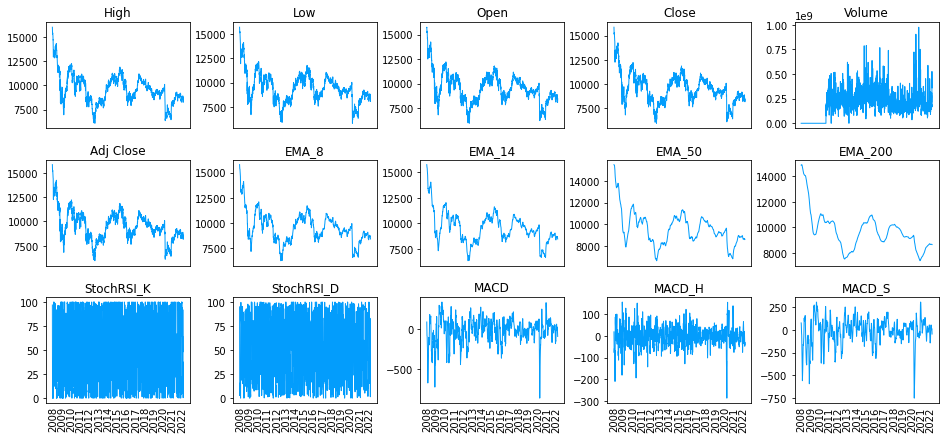

In [117]:
# Plot each column
register_matplotlib_converters()
nrows = 3
ncols = int(round(dfWithRelevantFeatures.shape[1] / nrows, 0))
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, figsize=(16, 7))
fig.subplots_adjust(hspace=0.3, wspace=0.3)
x = dfWithRelevantFeatures.index
columns = dfWithRelevantFeatures.columns
f = 0
for i in range(nrows):
    for j in range(ncols):
        ax[i, j].xaxis.set_major_locator(mdates.YearLocator())
        assetname = columns[f]
        y = dfWithRelevantFeatures[assetname]
        f += 1
        ax[i, j].plot(x, y, color='#039dfc', label=stockname, linewidth=1.0)
        ax[i, j].set_title(assetname)
        ax[i, j].tick_params(axis="x", rotation=90, labelsize=10, length=0)  

In [118]:
train_data, remaining_data = np.split(dfWithRelevantFeatures, [int(.8 *len(dfWithRelevantFeatures))])
val_data, test_data = np.split(remaining_data, [int(.5 *len(remaining_data))])
print(train_data.shape,val_data.shape,test_data.shape)

(2902, 16) (363, 16) (363, 16)


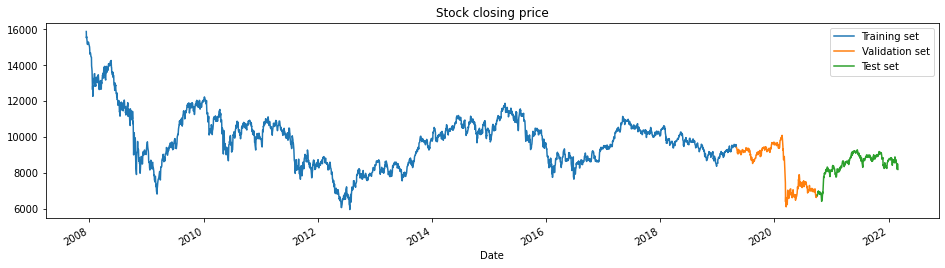

In [119]:
train_data["Close"].plot(figsize=(16,4),legend=True)
val_data["Close"].plot(figsize=(16,4),legend=True)
test_data["Close"].plot(figsize=(16,4),legend=True)
plt.legend(['Training set', 'Validation set', 'Test set'])
plt.title('Stock closing price')
plt.show()

In [120]:
sc = MinMaxScaler()
train = sc.fit_transform(train_data)
val = sc.fit_transform(val_data)
test = sc.fit_transform(test_data)
print(train.shape,val.shape,test.shape)

# Creating a separate scaler that works on a single column for scaling predictions
scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(dfWithRelevantFeatures['Close'])
np_Close_scaled = scaler_pred.fit_transform(df_Close)

(2902, 16) (363, 16) (363, 16)


In [121]:
# MODEL TRAINING PARAMS
timesteps = 90 # 60 is default
hl = [40, 35] #[40,35] is default
lr = 0.001 # 0.001 is default
batch_size = 32 # 32 is default
num_epochs = 1000 # 1000 is default

In [122]:
"""
# HYPERPARAMETER OPTIMISATION
batch_sizes = [32, 64]
timesteps_list = [30, 90]
lrs = [0.0005, 0.001]
for batch in batch_sizes:
    for timestep in timesteps_list:
        for lrt in lrs:
            model,train_error,val_error = fit_model(train,val,timestep,hl,lrt,batch,num_epochs)
            mse, rmse, r2_value,true,predictions,mape,mdape = evaluate_model(model,test,timestep)
            print("MODEL WITH BATCH SIZE OF ", batch, " AND TIMESTEP OF ", timestep, "AND LR OF ", lrt)
            print('MSE = {}'.format(mse))
            print('RMSE = {}'.format(rmse))
            print('R-Squared Score = {}'.format(r2_value))
            print('Mean Absolute Percentage Error (MAPE): ' + str(np.round(mape, 2)) + ' %')
            print('Median Absolute Percentage Error (MDAPE): ' + str(np.round(mdape, 2)) + ' %')
"""

'\n# HYPERPARAMETER OPTIMISATION\nbatch_sizes = [32, 64]\ntimesteps_list = [30, 90]\nlrs = [0.0005, 0.001]\nfor batch in batch_sizes:\n    for timestep in timesteps_list:\n        for lrt in lrs:\n            model,train_error,val_error = fit_model(train,val,timestep,hl,lrt,batch,num_epochs)\n            mse, rmse, r2_value,true,predictions,mape,mdape = evaluate_model(model,test,timestep)\n            print("MODEL WITH BATCH SIZE OF ", batch, " AND TIMESTEP OF ", timestep, "AND LR OF ", lrt)\n            print(\'MSE = {}\'.format(mse))\n            print(\'RMSE = {}\'.format(rmse))\n            print(\'R-Squared Score = {}\'.format(r2_value))\n            print(\'Mean Absolute Percentage Error (MAPE): \' + str(np.round(mape, 2)) + \' %\')\n            print(\'Median Absolute Percentage Error (MDAPE): \' + str(np.round(mdape, 2)) + \' %\')\n'

In [ ]:
# train the model
model,train_error,val_error = fit_model(train,val,timesteps,hl,lr,batch_size,num_epochs)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_9 (GRU)                  (None, 90, 16)            1632      
_________________________________________________________________
gru_10 (GRU)                 (None, 90, 40)            6960      
_________________________________________________________________
gru_11 (GRU)                 (None, 35)                8085      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 36        
Total params: 16,713
Trainable params: 16,713
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/1000
88/88 [==============================] - 11s 27ms/step - loss: 0.0159 - val_loss: 0.0264
Epoch 2/1000
88/88 [==============================] - 1s 16ms/step - loss: 0.0025 - val_loss: 0.0332
Epoch 3/1000
88/88 [====================

88/88 [==============================] - 2s 17ms/step - loss: 0.0026 - val_loss: 0.0124
Epoch 71/1000
88/88 [==============================] - 1s 16ms/step - loss: 0.0021 - val_loss: 0.0089
Epoch 72/1000
88/88 [==============================] - 1s 16ms/step - loss: 8.3565e-04 - val_loss: 0.0031
Epoch 73/1000
88/88 [==============================] - 1s 16ms/step - loss: 2.3140e-04 - val_loss: 0.0038
Epoch 74/1000
88/88 [==============================] - 2s 18ms/step - loss: 3.9517e-04 - val_loss: 0.0025
Epoch 75/1000
88/88 [==============================] - 1s 16ms/step - loss: 2.5554e-04 - val_loss: 0.0041
Epoch 76/1000
88/88 [==============================] - 2s 18ms/step - loss: 4.3387e-04 - val_loss: 0.0023
Epoch 77/1000
88/88 [==============================] - 1s 17ms/step - loss: 2.6255e-04 - val_loss: 0.0041
Epoch 78/1000
88/88 [==============================] - 2s 17ms/step - loss: 4.3025e-04 - val_loss: 0.0022
Epoch 79/1000
88/88 [==============================] - 2s 17ms/step 

88/88 [==============================] - 2s 18ms/step - loss: 2.0407e-04 - val_loss: 0.0026
Epoch 148/1000
88/88 [==============================] - 2s 18ms/step - loss: 3.4544e-04 - val_loss: 0.0033
Epoch 149/1000
88/88 [==============================] - 2s 19ms/step - loss: 5.4808e-04 - val_loss: 0.0037
Epoch 150/1000
88/88 [==============================] - 2s 18ms/step - loss: 2.2782e-04 - val_loss: 0.0019
Epoch 151/1000
88/88 [==============================] - 2s 18ms/step - loss: 1.5045e-04 - val_loss: 0.0025
Epoch 152/1000
88/88 [==============================] - 2s 19ms/step - loss: 1.8773e-04 - val_loss: 0.0023
Epoch 153/1000
88/88 [==============================] - 2s 19ms/step - loss: 1.3366e-04 - val_loss: 0.0026
Epoch 154/1000
88/88 [==============================] - 2s 19ms/step - loss: 3.5377e-04 - val_loss: 0.0041
Epoch 155/1000
88/88 [==============================] - 2s 19ms/step - loss: 3.6967e-04 - val_loss: 0.0035
Epoch 156/1000
88/88 [==============================

In [140]:
# OR load the model
model = load_model("GRU_GPU_AAPL_15Y_withTA_klines.h5")


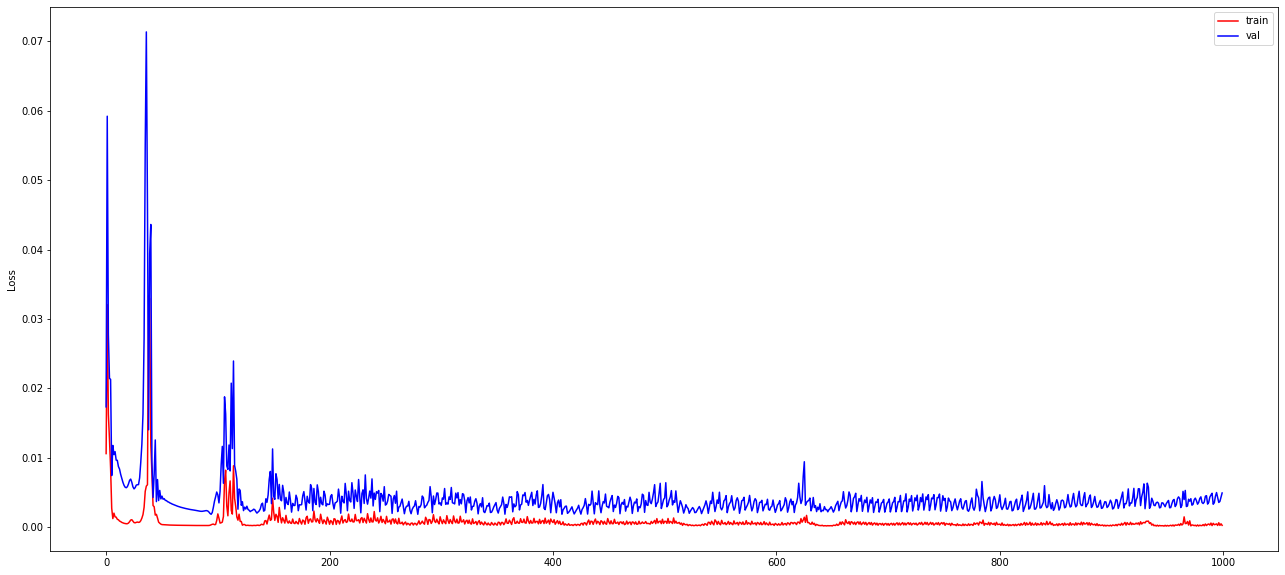

In [92]:
plt.rcParams["figure.figsize"] = (22,10)
plt.plot(train_error,c = 'r')
plt.plot(val_error,c = 'b')
plt.ylabel('Loss')
plt.legend(['train','val'],loc = 'upper right')
plt.show()

In [93]:
mse, rmse, r2_value,true,predictions,mape,mdape = evaluate_model(model,test,timesteps)
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r2_value))
print('Mean Absolute Percentage Error (MAPE): ' + str(np.round(mape, 2)) + ' %')
print('Median Absolute Percentage Error (MDAPE): ' + str(np.round(mdape, 2)) + ' %')



MSE = 0.0063510340621791405
RMSE = 0.07969337527159419
R-Squared Score = 0.8578275177488884
Mean Absolute Percentage Error (MAPE): 45.06 %
Median Absolute Percentage Error (MDAPE): 27.01 %


In [102]:
# FIX DATES (X AXIS) and add differences at the bottom of the graph just like in v2
true_unscaled = scaler_pred.inverse_transform(true.reshape(-1, 1))
predictions_unscaled = (scaler_pred.inverse_transform(predictions))
diff = predictions_unscaled - true_unscaled
percent_diff = (abs(predictions_unscaled - true_unscaled) / true_unscaled) * 100.0
abs_diff = abs(diff)
valid = pd.DataFrame()
valid['Difference'] = diff.flatten()
valid['Abs_Difference'] = abs_diff.flatten()
valid['Percent_Difference'] = percent_diff.flatten()
print(valid)
print("abs diff mean: ", valid['Abs_Difference'].mean())
print("abs diff median: ", valid['Abs_Difference'].median())
print("percent diff mean: ", valid['Percent_Difference'].mean())
print("percent diff median: ", valid['Percent_Difference'].median())
print(valid.describe())
"""
diffa = predictions - true.reshape(-1, 1)
valida = pd.DataFrame()
valida['Difference'] = diffa.flatten()
print(valida.describe())
"""

    Difference  Abs_Difference  Percent_Difference
0     1.066559        1.066559            1.493673
1    -2.017984        2.017984            2.845780
2     3.990364        3.990364            6.016114
3    -1.758177        1.758177            2.753182
4    -2.811300        2.811300            4.178516
..         ...             ...                 ...
71    3.769426        3.769426            2.725744
72    4.353939        4.353939            3.491098
73    6.134894        6.134894            4.995375
74    2.794051        2.794051            2.513171
75   -3.206609        3.206609            2.690562

[76 rows x 3 columns]
abs diff mean:  9.11626702600815
abs diff median:  6.92593865883471
percent diff mean:  6.71188021323486
percent diff median:  5.424178214844418
       Difference  Abs_Difference  Percent_Difference
count   76.000000       76.000000           76.000000
mean    -6.744191        9.116267            6.711880
std      9.589768        7.337561            5.265267
min 

"\ndiffa = predictions - true.reshape(-1, 1)\nvalida = pd.DataFrame()\nvalida['Difference'] = diffa.flatten()\nprint(valida.describe())\n"

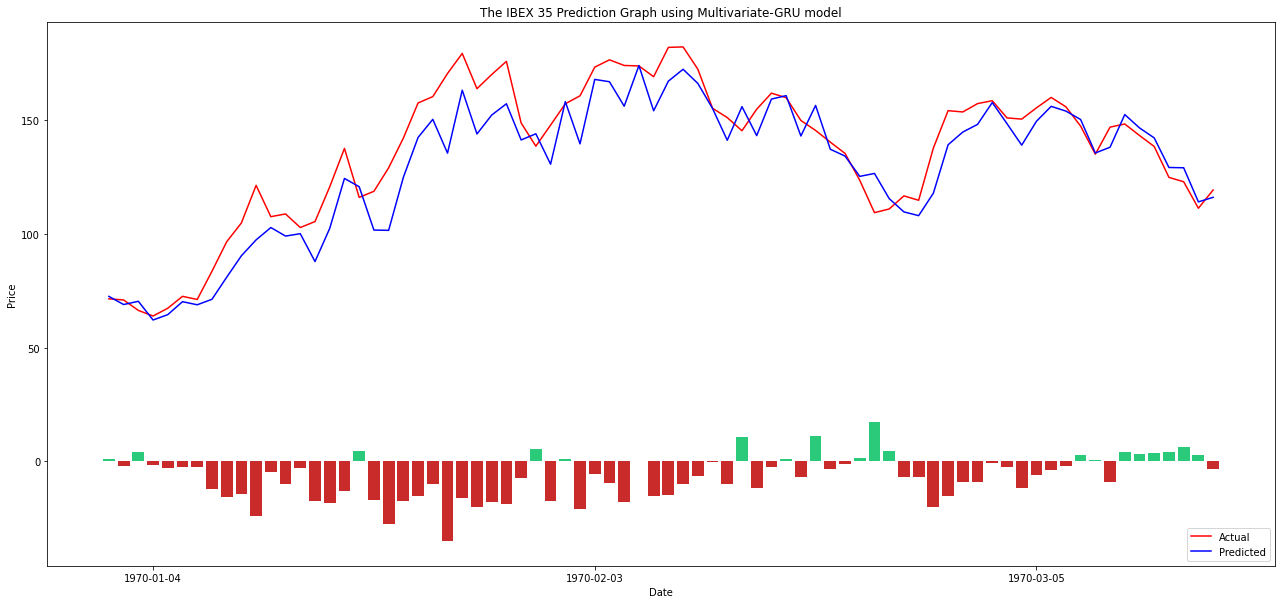

In [95]:
ind = np.arange(len(valid))
                        
plt.rcParams["figure.figsize"] = (22,10)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d')) 
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=30)) 
plt.plot(true_unscaled,c = 'r')
plt.plot(predictions_unscaled,c = 'b')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Apple Prediction Graph using Multivariate-GRU model')
plt.legend(['Actual','Predicted'],loc = 'lower right')

y = valid["Difference"]
valid.loc[y >= 0, 'diff_color'] = "#2BC97A"
valid.loc[y < 0, 'diff_color'] = "#C92B2B"
plt.bar(ind, y, width=0.8, color=valid['diff_color'])

plt.show()

In [196]:
# save the model to disk
model.save("GRU_GPU_IBEX_5Y_withTA_klines.h5")

In [96]:
# BACKTESTING feature
# THIS IS ALL-IN STRATEGY - BUY AND SELL WITH THE MAXIMUM AMOUNT OF MONEY AVAILABLE
CADENCES = [1,3,7]
for CADENCE in CADENCES:
    money = 1000
    correct = 0
    total = 0
    for i in range (0, len(predictions_unscaled), CADENCE):
        #print(i)
        if i > 0:
            total = total + 1
            todays_pred = float(predictions_unscaled[i])
            yesterdays_pred = float(predictions_unscaled[i-CADENCE])
            todays_price = float(true_unscaled[i])
            yesterdays_price = float(true_unscaled[i-CADENCE])
            percent_diff = (abs(todays_price - yesterdays_price) / yesterdays_price) * 100.0
            #print(percent_diff)
            if todays_pred > yesterdays_pred:
                #print("Predicting price rise. Current pred: ", yesterdays_pred, "predicted price: ", todays_pred)
                if todays_price > yesterdays_price:
                    #print("Prediction was correct! Price was rising", yesterdays_price, " -> ", todays_price)
                    money = money + (money * (percent_diff / 100))
                    #print("Current amount: ", money)
                    #print("\n")
                    correct = correct + 1

                else:
                    #print("Prediction was wrong...", yesterdays_price, " -> ", todays_price)
                    money = money - (money * (percent_diff / 100))
                    #print("Current amount: ", money)
                    #print("\n")


            else:
                #print("Predicting price fall. Current pred: ", yesterdays_pred, "predicted price: ", todays_pred)
                if todays_price < yesterdays_price:
                    #print("Prediction was correct! Price was falling", yesterdays_price, " -> ", todays_price)
                    money = money + (money * (percent_diff / 100))
                    #print("Current amount: ", money)
                    #print("\n")
                    correct = correct + 1
                else:
                    #print("Prediction was wrong...", yesterdays_price, " -> ", todays_price)
                    money = money - (money * (percent_diff / 100))
                    #print("Current amount: ", money)
                    #print("\n")
    print("CADENCE: ", CADENCE)
    print("Correct: ", correct, " and total: ", total)
    print("Final amount: ", money)
    print("Total model accuracy: ", correct/total*100, "%")
    print("\n")

CADENCE:  1
Correct:  54  and total:  75
Final amount:  11474.269953022384
Total model accuracy:  72.0 %


CADENCE:  3
Correct:  23  and total:  25
Final amount:  11367.947479047807
Total model accuracy:  92.0 %


CADENCE:  7
Correct:  9  and total:  10
Final amount:  2904.2339083596853
Total model accuracy:  90.0 %




In [100]:
# BACKTESTING feature
# THIS IS ALL-IN STRATEGY - BUY AND SELL WITH THE MAXIMUM AMOUNT OF MONEY AVAILABLE
CADENCES = [1,3,7]
for CADENCE in CADENCES:
    money = 1000
    correct = 0
    total = 0
    for i in range (0, len(predictions_unscaled)):
        #print(i)
        if i > CADENCE - 1:
            total = total + 1
            todays_pred = float(predictions_unscaled[i])
            yesterdays_pred = float(predictions_unscaled[i-CADENCE])
            todays_price = float(true_unscaled[i])
            yesterdays_price = float(true_unscaled[i-CADENCE])
            percent_diff = (abs(todays_price - yesterdays_price) / yesterdays_price) * 100.0
            #print(percent_diff)
            if todays_pred > yesterdays_pred:
                #print("Predicting price rise. Current pred: ", yesterdays_pred, "predicted price: ", todays_pred)
                if todays_price > yesterdays_price:
                    #print("Prediction was correct! Price was rising", yesterdays_price, " -> ", todays_price)
                    money = money + (money * (percent_diff / 100))
                    #print("Current amount: ", money)
                    #print("\n")
                    correct = correct + 1

                else:
                    #print("Prediction was wrong...", yesterdays_price, " -> ", todays_price)
                    money = money - (money * (percent_diff / 100))
                    #print("Current amount: ", money)
                    #print("\n")


            else:
                #print("Predicting price fall. Current pred: ", yesterdays_pred, "predicted price: ", todays_pred)
                if todays_price < yesterdays_price:
                    #print("Prediction was correct! Price was falling", yesterdays_price, " -> ", todays_price)
                    money = money + (money * (percent_diff / 100))
                    #print("Current amount: ", money)
                    #print("\n")
                    correct = correct + 1
                else:
                    #print("Prediction was wrong...", yesterdays_price, " -> ", todays_price)
                    money = money - (money * (percent_diff / 100))
                    #print("Current amount: ", money)
                    #print("\n")
    print("CADENCE: ", CADENCE)
    print("Correct: ", correct, " and total: ", total)
    print("Final amount: ", money)
    print("Total model accuracy: ", correct/total*100, "%")
    print("\n")

CADENCE:  1
Correct:  54  and total:  75
Final amount:  11474.269953022384
Total model accuracy:  72.0 %


CADENCE:  3
Correct:  63  and total:  73
Final amount:  981362.5646812965
Total model accuracy:  86.3013698630137 %


CADENCE:  7
Correct:  63  and total:  69
Final amount:  118681653.93799746
Total model accuracy:  91.30434782608695 %


